# Diffusion hyperparameter estimation
For optimal performance, we need to adjust two families of hyperparameters: the data reparametrization and the diffusion noise schedule. This notebook will guide you through that.

In [1]:
!export CUDA_HOME=/usr/local/cuda-11.7

In [3]:
from data.dataloader import get_dataloader
from omegaconf import OmegaConf

Using /home/mathi/.cache/torch_extensions/py310_cu117 as PyTorch extensions root...
No modifications detected for re-loaded extension module _pvcnn_backend, skipping build step...
Loading extension module _pvcnn_backend...


In [4]:
opt = OmegaConf.load('configs/overfit_room.yml')
opt.distribution_type = "single"
loader ,*_ = get_dataloader(opt)

2023-10-10 15:55:20.216 | INFO     | data.dataloader:get_dataloader:43 - Loading IndoorScenes dataset, which is currently only for overfitting on one scene!


2023-10-10 15:55:23.379 | INFO     | data.arkit:__init__:58 - Downsampled to voxel size: 0.05
2023-10-10 15:55:23.380 | INFO     | data.arkit:__init__:59 - Number of points in arkit: 48968
2023-10-10 15:55:23.380 | INFO     | data.arkit:__init__:60 - Number of points in faro: 54970


In [5]:
import torch

data = torch.tensor([])
nbatches = 100

for idx, batch in enumerate(loader):
    data = torch.cat([data, batch['train_points']], dim=0)
    if idx == nbatches:
        break 

data.shape

torch.Size([101, 50000, 3])

Create a placeholder reparametrization and use it to estimate data statistics. If you're setting parameters for a UVL-parametrized model, simply change `GaussianReparam` to `UVLReparam` below and adjust the parameter names.

With `GaussianReparam` this step is not necessary since normalization with parameters mean=0, sigma=1 effectively does nothing. It is however important for `UVLReparam`.

Compute mean/standard deviation of the data across the 3 axes and plot as histograms.

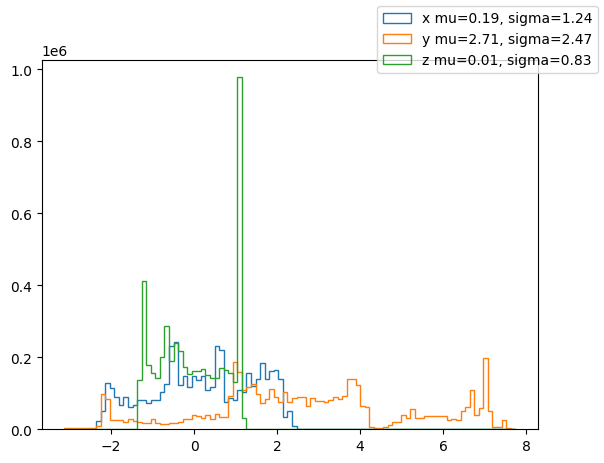

In [6]:
%matplotlib inline
from torch import Tensor
import matplotlib.pyplot as plt


def data_statistics(data: Tensor) -> tuple[Tensor, Tensor]:
    x, y, z = data.unbind(-1)
    fig, ax = plt.subplots()
    kw = dict(histtype='step', bins=torch.linspace(data.min(), data.max(), 100))
    ax.hist(x.flatten(), label=f'x mu={x.mean().item():.02f}, sigma={x.std().item():0.2f}', **kw)
    ax.hist(y.flatten(), label=f'y mu={y.mean().item():.02f}, sigma={y.std().item():0.2f}', **kw)
    ax.hist(z.flatten(), label=f'z mu={z.mean().item():.02f}, sigma={z.std().item():0.2f}', **kw)
    fig.legend()

    mean = data.mean(dim=(0, 1))
    sigma = data.std(dim=(0, 1))

    return mean, sigma

mean_raw, sigma_raw = data_statistics(data)

## Reparametrization hyperparameters

Use the estimated parameters to compute the parameters to be used in your `config.py`. Copy-paste from the cell below.

Sanity check: use it on the data and visually check that the data is reasonably approximating the normal distribution.

Now that the data is properly normalized we can take care of the noise schedule. A conservative rule of thumb is that we want to diffuse the data until every example (point cloud) can reasonably likely be confused for any other. This means that we want the $\sigma_{max}$ to be around the maximum pairwise distance between data examples. We compute the pairwise distance matrix and take the max.

There are two caveats: 
1. We're using only a subset of the dataset here, as computing the entire pairwise distance matrix would be prohibitive. We may therefore be underestimating this distance.
2. For conditional diffusion the conditioning signal can provide a lot of disambiguating information so there is no actual need to diffuse a car to the point of being confusable with an airplane. We may therefore be overestimating the value.

This is therefore just a rule of thumb for starting with a new dataset. You can likely get good results faster if you reduce this parameter afterwards.

The value to use for sigma_max of your noise schedule is 160.38172912597656.


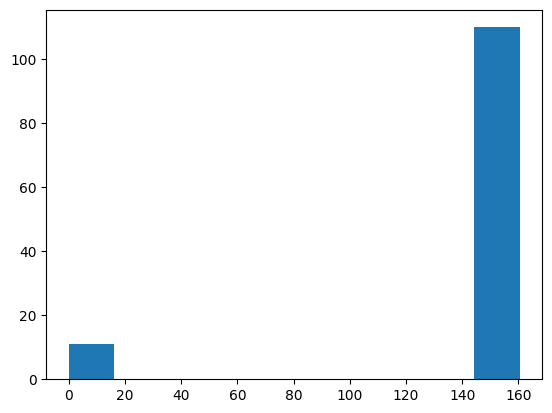

In [10]:
from einops import rearrange

diff_flat = rearrange(data, 'b n d -> b (n d)')

distm = torch.cdist(diff_flat, diff_flat)
print(f'The value to use for sigma_max of your noise schedule is {distm.max().item()}.')
_ = plt.hist(distm.flatten()) # show a histogram of the distances for better intuition